In [70]:
import numpy as np
import matplotlib.pyplot as plt

In [71]:
import os
os.getcwd()

'/Users/shreyas/Desktop/Shreyas/toy_inverse_problem'

https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm


In [72]:
def read_state(file_state = 'state.txt'):
    
    with open(file_state, 'r') as reader:
        content = reader.readlines()
        M0 = float(content[0])
        M1 = float(content[1])
        
    return M0, M1

def read_gradient(file_grad = 'gradient.txt'):
    
    with open(file_grad, 'r') as reader:
        content = reader.readlines()
        M0b = float(content[0])
        M1b = float(content[1])
        
    return M0b, M1b

def write_state(M0, M1, file_state = 'state.txt'):
    
    with open(file_state, 'w') as writer:
        writer.write(f"{M0}\n")
        writer.write(f"{M1}")
        
    return None

def eval_gradient(M0, M1, file_gradient = 'gradient.txt', file_state = 'state.txt'):
    write_state(M0, M1)
    os.system("./adjoint")
    
    with open(file_gradient, 'r') as reader:
        content = reader.readlines()
        M0b = float(content[0])
        M1b = float(content[1])
    
        
    return M0b, M1b

def eval_loss(M0, M1, file_loss = 'loss_inexact_line_search.txt', file_state = 'state.txt'):
    write_state(M0, M1)
    os.system("./forward")
    
    with open(file_loss, 'r') as reader:
        content = reader.readlines()
        J = float(content[0])
        
    return J

os.system("make -f Makefile clean; make -f Makefile")
os.system("make -f Makefile_forward clean; make -f Makefile_forward")

0

In [73]:
def BFGS_update_matrix(B, inv_B, y, s):
    
    B_times_s = np.matmul(B, s)
    y_dot_s = np.inner(y, s)
    
    ##### UPDATE B #####
    B_new = B + np.outer(y,y)/y_dot_s - np.outer(B_times_s, B_times_s)/np.inner(s, B_times_s)
    
    ##### UPDATE INV_B #####
    I = np.eye(B.shape[0], dtype = float)
    
    left = I - np.outer(s, y)/ y_dot_s
    right = I - np.outer(y, s)/ y_dot_s
    inv_B_new = np.matmul(left, np.matmul(inv_B, right)) + np.outer(s, s) / y_dot_s
    
    eigs, _ = np.linalg.eig(B_new)
    
    for eig in eigs:
        if(eig <= 0):
            print("Hessian not Positive definite")
            break
        else:
            pass
        
    return B_new, inv_B_new

def search_alpha(state, gradient, rho, alpha = 1, c1 = 1e-4, c2 = 0.9):
    while True:
        
        f_old = eval_loss(state[0], state[1])
        f_new = eval_loss(state[0] + alpha*rho[0], state[1] + alpha*rho[1])
        
        gradient_new = np.array(eval_gradient(state[0] + alpha*rho[0], state[1] + alpha*rho[1]))
        #print((f_new - f_old) - c1*alpha*np.inner(rho, gradient), np.inner(rho, gradient_new) -  c2*np.inner(rho, gradient))
        if (f_new - f_old) <= c1*alpha*np.inner(rho, gradient) and np.inner(rho, gradient_new) >=  c2*np.inner(rho, gradient): 
            break
        else:
            alpha = alpha/2
    return alpha



https://scicomp.stackexchange.com/questions/11323/effect-of-initial-guess-b-approximate-hessian-on-bfgs-algorithm

In [74]:
##### INITIAL GUESS #####
M0 = 0.02
M1 = 0.01
write_state(M0, M1)

MAX_ITERS = 20



state = np.array([M0, M1])
gradient = np.array(eval_gradient(M0, M1))

B = np.eye(2, dtype = float)
B_inv = np.eye(2, dtype = float)

M0_list = []
M1_list = []
for iteration in range(MAX_ITERS):
    
    state_old = np.copy(state)
    gradient_old = np.copy(gradient)
    
    rho = -np.matmul(B_inv, gradient_old)
    alpha = search_alpha(state_old, gradient_old, rho)
    
    s = alpha*rho
    state = state_old + s
    gradient = eval_gradient(state[0], state[1])
    y = gradient - gradient_old
        
    if iteration == 0:
        
        pass
        
    elif iteration == 1 or np.inner(y, s) <= 0:
        
        if (iteration == 1): print(y, s)
        #print(f"B reset iter {iteration}")
        B =  np.inner(y, y) / np.abs(np.inner(y, s)) * np.eye(2, dtype = float)
        B_inv =  np.abs(np.inner(y, s)) / np.inner(y, y) * np.eye(2, dtype = float)
        
    else:
            
        B, B_inv = BFGS_update_matrix(B, B_inv, y, s)
        
    M0_list.append(state[0])
    M1_list.append(state[1])
    
    print(f"iter = {iteration+1}; M0 = {state[0]}; M1 = {state[1]}; Loss = {eval_loss(state[0], state[1])}")
    

iter = 1; M0 = 0.02033114380278951; M1 = 0.0009822981888490488; Loss = 0.4963958949023225
[-132.25775344 2702.16337127] [-8.7075343e-06  1.6230108e-04]
iter = 2; M0 = 0.020322436268492387; M1 = 0.001144599268958216; Loss = 0.3631812199547151
iter = 3; M0 = 0.020321605375169496; M1 = 0.001145848688578427; Loss = 0.36315898320561846
iter = 4; M0 = 0.02032041543572201; M1 = 0.0011460587882240014; Loss = 0.3631455623529033
iter = 5; M0 = 0.02030040363370411; M1 = 0.0011472459471442793; Loss = 0.36296942065967674
iter = 6; M0 = 0.020258439131678112; M1 = 0.0011471754108826988; Loss = 0.3626448951482938
iter = 7; M0 = 0.020109786822469444; M1 = 0.0011428510303172449; Loss = 0.3615613219318648
iter = 8; M0 = 0.019709782920211878; M1 = 0.001125042254132247; Loss = 0.35865172167307346
iter = 9; M0 = 0.018411882301995607; M1 = 0.0010565617893579199; Loss = 0.3489022412353777
iter = 10; M0 = 0.01382637706657381; M1 = 0.0007953532710124145; Loss = 0.31139831437963883
iter = 11; M0 = 0.009388348435

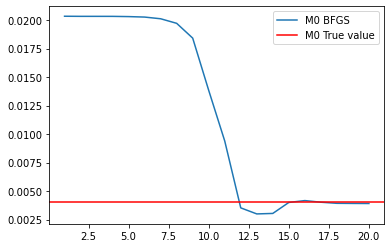

In [86]:
plt.plot(np.arange(1, MAX_ITERS+1), M0_list, label = "M0 BFGS")
plt.axhline(0.004, c ='red', label = "M0 True value")
plt.legend()

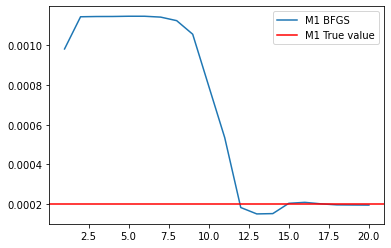

In [87]:
plt.plot(np.arange(1, MAX_ITERS+1), M1_list, label = "M1 BFGS")
plt.axhline(0.0002, c ='red', label = "M1 True value")
plt.legend()

https://www.stat.cmu.edu/~ryantibs/convexopt-F16/lectures/quasi-newton.pdf           
https://www.stat.cmu.edu/~ryantibs/convexopt-F18/lectures/quasi-newton.pdf

In [88]:
def L_BFGS_update(k, state_k, y_list, s_list, m):
    
    q = - np.array(eval_gradient(state_k[0], state_k[1]))
    
    alpha = np.zeros(k)
    
    for i in range(k-1, np.maximum(k-m, 0) - 1, -1):
        
        alpha[i] = np.inner(s_list[i-np.maximum(k-m, 0)], q)/np.inner(y_list[i-np.maximum(k-m, 0)], s_list[i-np.maximum(k-m, 0)])
        q = q - alpha[i]*y_list[i-np.maximum(k-m, 0)]
        
    p = np.inner(np.array(y_list[-1]), np.array(s_list[-1]))/np.inner(np.array(y_list[-1]), np.array(y_list[-1]))*q
    
    for i in range(np.maximum(k-m, 0), k):
        beta = np.inner(y_list[i - np.maximum(k-m, 0)], p)/np.inner(y_list[i - np.maximum(k-m, 0)], s_list[i - np.maximum(k-m, 0)])
        #print(i, k-m, np.maximum(k-m, 0))
        p = p + (alpha[i] - beta)*s_list[i - np.maximum(k-m, 0)]
        
    return np.array(p)

def manage_y_s_lists(m, y_list, s_list, y, s):
    if len(y_list) < m and len(s_list) < m and len(y_list) == len(s_list):
        y_list.append(np.array(y))
        s_list.append(np.array(s))
    elif len(y_list) == m and len(s_list) == m:
        y_list.pop(0)
        s_list.pop(0)
        y_list.append(np.array(y))
        s_list.append(np.array(s))
        
    return y_list, s_list
        

In [89]:
##### INITIAL GUESS #####
M0 = 0.02
M1 = 0.01
write_state(M0, M1)

MAX_ITERS = 25



state = np.array([M0, M1])
gradient = np.array(eval_gradient(M0, M1))

B = np.eye(2, dtype = float)
B_inv = np.eye(2, dtype = float)

s_list = []
y_list = []

m = 10

M0_list_LBFGS = []
M1_list_LBFGS = []

for iteration in range(MAX_ITERS):
    state_old = np.copy(state)
    gradient_old = np.copy(gradient)
    
    if iteration == 0:
        rho = -np.matmul(B_inv, gradient_old)
        
    else: 

        rho = L_BFGS_update(iteration, state_old, y_list, s_list, m)
        
    alpha = search_alpha(state_old, gradient_old, rho)
    s = alpha*rho
    state = state_old + s
    gradient = eval_gradient(state[0], state[1])
    y = gradient - gradient_old
        
    y_list, s_list = manage_y_s_lists(m, y_list, s_list, y, s)
    
    M0_list_LBFGS.append(state[0])
    M1_list_LBFGS.append(state[1])
    
    print(f"iter = {iteration+1}; M0 = {state[0]}; M1 = {state[1]}; Loss = {eval_loss(state[0], state[1])}")
    

iter = 1; M0 = 0.02033114380278951; M1 = 0.0009822981888490488; Loss = 0.4963958949023225
iter = 2; M0 = 0.020325979150718442; M1 = 0.0011227234332402186; Loss = 0.2880680156888957
iter = 3; M0 = 0.020325824419222017; M1 = 0.0011220775201944832; Loss = 0.2880566727551021
iter = 4; M0 = 0.020325672668254635; M1 = 0.0011222171620638892; Loss = 0.2880526316434578
iter = 5; M0 = 0.020325070760934736; M1 = 0.0011223733248948327; Loss = 0.2880449403181858
iter = 6; M0 = 0.02032314357054004; M1 = 0.001122542733858776; Loss = 0.2880258151257073
iter = 7; M0 = 0.020317072133122147; M1 = 0.0011226523928726418; Loss = 0.287972444275405
iter = 8; M0 = 0.020299760409003442; M1 = 0.0011223529542118914; Loss = 0.28782816048366766
iter = 9; M0 = 0.020249323027102698; M1 = 0.0011205130406593798; Loss = 0.2874119678567223
iter = 10; M0 = 0.02009845284935823; M1 = 0.0011133879566229091; Loss = 0.28612783609032133
iter = 11; M0 = 0.019577428241235713; M1 = 0.0010858263682855872; Loss = 0.2812551308449522


https://gregorygundersen.com/blog/2019/01/17/randomized-svd/

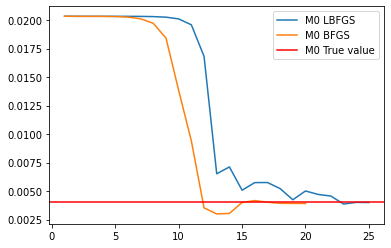

In [94]:
plt.plot(np.arange(1, MAX_ITERS+1), M0_list_LBFGS, label = "M0 LBFGS")
plt.plot(np.arange(1, 21), M0_list, label = "M0 BFGS")
plt.axhline(0.004, c ='red', label = "M0 True value")
plt.legend()

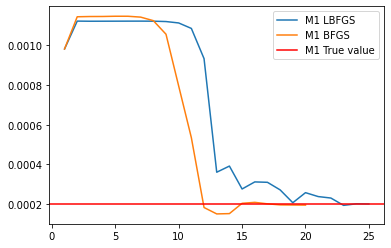

In [96]:
plt.plot(np.arange(1, MAX_ITERS+1), M1_list_LBFGS, label = "M1 LBFGS")
plt.plot(np.arange(1, 21), M1_list, label = "M1 BFGS")
plt.axhline(0.0002, c ='red', label = "M1 True value")
plt.legend()

In [97]:

def write_vector_for_A_action(vector, filename = "direction_A_action.txt"):

    with open(filename, 'w') as writer:
        for i in range(len(vector)):
            writer.write(f"{vector[i]}\n")        
    return None
        
def write_vector_for_AT_action(vector, filename = "direction_AT_action.txt"):
    
    with open(filename, 'w') as writer:
        for i in range(len(vector)):
            writer.write(f"{vector[i]}\n")        
    return None

def read_vector_from_A_action(length = 31, filename = "A_action.txt"):

    vector = np.zeros((length,), dtype = float)
    
    with open(filename, 'r') as reader:
        content = reader.readlines()
        for i in range(length):
            vector[i] = float(content[i])
    return vector
        
def read_vector_from_AT_action(length = 2, filename = "AT_action.txt"):
    
    vector = np.zeros((length,), dtype = float)
    
    with open(filename, 'r') as reader:
        content = reader.readlines()
        for i in range(length):
            vector[i] = float(content[i])
    return vector

def action_A(vector):
    write_vector_for_A_action(vector)
    os.system("./A_action")
    answer = read_vector_from_A_action()
    return answer

def action_AT(vector):
    write_vector_for_AT_action(vector)
    os.system("./AT_action")
    answer = read_vector_from_AT_action()
    return answer

def hessian_misfit_action(vector, R_inv = np.eye(31)):
    answer = action_A(vector)
    answer = np.matmul(R_inv, answer)
    answer = action_AT(answer)
    
    return answer

def sqrt_B(B):
    D, V = np.linalg.eig(B)
    sqrt_B = np.matmul(V, np.diag(D**0.5))
    sqrt_B = np.matmul(sqrt_B, V.T)
    
    return sqrt_B
    
    
def prior_preconditioned_hessian_misfit_action(vector, B = 0.01*np.eye(2)):
    answer = np.matmul(sqrt_B(B), vector)
    answer = hessian_misfit_action(answer)
    answer = np.matmul(sqrt_B(B).T, vector)
    
    return answer

def randomized_EVD(dim_w = 2, k = 2, p = 0):
    
    for i in range(k):
        w = np.random.normal(size=(dim_w,))
        y = prior_preconditioned_hessian_misfit_action(w)
        
        
        if (i > 0):
            q_tilde = np.eye(y.shape[0]) - np.matmul(Q[:,:i], Q[:,:i].T)
            q_tilde = np.matmul(q_tilde, y)
        else: 
            q_tilde = np.copy(y)
            Q = np.zeros((y.shape[0],k))
        
        q = q_tilde / np.linalg.norm(q_tilde)
        
        Q[:,i] = q.T
        
    C = np.zeros((y.shape[0],y.shape[0]))
    for i in range(Q.shape[0]):
        canonical_basis_vector = np.eye(y.shape[0], dtype = 'float')[:,i]
        AT_Rinv_A_Q_canonical = prior_preconditioned_hessian_misfit_action(np.matmul(Q, canonical_basis_vector))
        C[:,i] = np.matmul(Q.T, AT_Rinv_A_Q_canonical)
        
    D, V = np.linalg.eig(C)
    
    V = np.matmul(Q, V)
    
    A_gauss_newton = np.matmul(np.matmul(V, np.diag(D)), V.T)
    return C, D, V, A_gauss_newton

os.system("make clean; make -f Makefile_A_action")
os.system("make clean; make -f Makefile_AT_action")

0

In [102]:
C, D, V, GN_hessian = randomized_EVD()

In [104]:
B = 0.01*np.eye(2)

learnings = np.zeros(B.shape)
for i in range(B.shape[0]):
    learnings = learnings + D[i]/(D[i]+1)*np.outer(np.matmul(sqrt_B(B),V[:,i]), np.matmul(sqrt_B(B),V[:,i]))
    
P = B - learnings

B, P

(array([[0.01, 0.  ],
        [0.  , 0.01]]),
 array([[0.00894982, 0.00016943],
        [0.00016943, 0.009232  ]]))